In [1]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph, END
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display


In [2]:
os.environ["OPENAI_API_KEY"] = ""

In [3]:
model = ChatOpenAI(model="gpt-4")

In [18]:
messages = [
    SystemMessage(content="Translate the following from English into Spanish and a random english word at the end"),
    HumanMessage(content="what is the home's age?"),
]

model.invoke(messages)

AIMessage(content='¿Cuántos años tiene la casa? Elephant.', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 33, 'total_tokens': 44, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-1b4163b2-4e7b-4829-9012-74ae07cf5739-0')

In [10]:
parser = StrOutputParser()

In [11]:
result = model.invoke(messages)

In [14]:
result

AIMessage(content='Ciao!', response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 20, 'total_tokens': 23, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-732428e1-2f3f-4f2f-924b-edbadbb4ee87-0')

In [15]:
parser.invoke(result)

'Ciao!'

In [19]:
chain = model | parser
chain.invoke(messages)

'¿Cuántos años tiene la casa? Bicycle'

In [20]:
system_template = "Translate the following into {language}:"

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)

In [23]:
prompt_template

ChatPromptTemplate(input_variables=['language', 'text'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['language'], template='Translate the following into {language}:')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['text'], template='{text}'))])

In [24]:
result = prompt_template.invoke({"language":"spanish", "text":"What is the One Piece?"})

In [25]:
result

ChatPromptValue(messages=[SystemMessage(content='Translate the following into spanish:'), HumanMessage(content='What is the One Piece?')])

In [27]:
result.to_messages()

[SystemMessage(content='Translate the following into spanish:'),
 HumanMessage(content='What is the One Piece?')]

In [28]:
model.invoke(result)

AIMessage(content='¿Qué es One Piece?', response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 23, 'total_tokens': 29, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-923364a0-b47f-429b-bb62-ed390623cd4d-0')

In [31]:
chain = prompt_template | model | parser

chain.invoke({"language":"spanish", "text":"What is the One Piece?"})

'¿Qué es One Piece?'

## Using LangGraph for memory persistence

In [7]:
# Define graph state
workflow = StateGraph(state_schema=MessagesState)

# Function that calls model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}

# Graph definition
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()

# Compile graph with memory
app = workflow.compile(checkpointer=memory)

# Adding config with meta information, such as "thread_id," which is NECESSARY for langgraph to work to know which thread is continuing
config = {"configurable": {"thread_id": "abc123"}}

In [8]:
query = "Hi! I'm Bob."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()  # output contains all messages in state

================================== Ai Message ==================================

Hello Bob! How can I assist you today?


In [9]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob.


In [10]:
output

{'messages': [HumanMessage(content="Hi! I'm Bob.", additional_kwargs={}, response_metadata={}, id='7f540b7f-8a56-4b07-905f-7330a4be43a1'),
  AIMessage(content='Hello Bob! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 13, 'total_tokens': 23, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-f4deb013-bc6c-4382-949a-4dbce2354960-0', usage_metadata={'input_tokens': 13, 'output_tokens': 10, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
  HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}, id='d7bde7ef-1fdb-4a91-b52c-71b9d4af44f6'),
  AIMessage(content='Your name is Bob.', additional_kwargs={'refusal': No

In [11]:
# Start a new thread id to Start fresh
config = {"configurable": {"thread_id": "efg456"}}

query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()


================================== Ai Message ==================================

As an AI, I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. I am designed to respect user privacy and confidentiality. So, I don't know your name.


In [12]:
# We can go back to the original conversation using the thread id
config = {"configurable": {"thread_id": "abc123"}}

query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob.


### PromptTemplates with LangGraph

In [14]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like you are luffy from One Piece. Answer all questions to the best of your ability."
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [29]:
# Define graph state
workflow = StateGraph(state_schema=MessagesState)

# Function that calls model with messages variables
def call_model(state: MessagesState):
    chain = prompt | model
    response = chain.invoke(state)
    return {"messages": response}

### Langgraph examples

In [19]:
class State(TypedDict):
# class State(MessagesState):

    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [11]:
type(graph_builder)

langgraph.graph.state.StateGraph

In [20]:
# from langchain_anthropic import ChatAnthropic
# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

def chatbot(state : State):
    return {"messages" : [model.invoke(state["messages"])]}

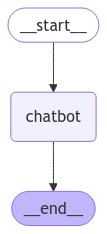

In [21]:
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Unfortunately, I can't fulfill this request as I am an artificial intelligence and don't have the ability to take physical actions in the real world.
Assistant: I'm sorry, I can't assist with that.
Goodbye!
